In [1]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `n

In [2]:
# Model 
class ActorCritic(tf.keras.Model):
    """Combined actor-critic network."""

    def __init__(
                  self, 
                  num_actions: int, 
                  num_hidden_units: int):
        """Initialize."""
        super().__init__()

        self.common = layers.Dense(num_hidden_units, activation="relu")
        self.actor = layers.Dense(num_actions)
        self.critic = layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        return self.actor(x), self.critic(x)
    
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

2022-07-15 14:07:53.257237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# create environment for training 
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns state, reward and done flag given an action."""

    state, reward, done, _ = env.step(action)
    return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
    return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

# Function to run a single episode 
def run_episode(
                initial_state: tf.Tensor,  
                model: tf.keras.Model, 
                max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Runs a single episode to collect training data."""
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

    initial_state_shape = initial_state.shape
    state = initial_state
    for t in tf.range(max_steps):
    #for t in range(max_steps):
        # Convert state into a batched tensor (batch size = 1)
        state = tf.expand_dims(state, 0)

        # Run the model and to get action probabilities and critic value
        action_logits_t, value = model(state)

        # Sample next action from the action probability distribution
        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log probability of the action chosen
        action_probs = action_probs.write(t, action_probs_t[0, action])

        # Apply action to the environment to get next state and reward
        state, reward, done = tf_env_step(action)
        state.set_shape(initial_state_shape)

        # Store reward
        rewards = rewards.write(t, reward)
        
        if tf.cast(done, tf.bool): 
            break
        #t = tf.cond(tf.equal(done, True), lambda: 10000000, lambda: t)

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()

    return action_probs, values, rewards

In [4]:
# Expected Returns 
def get_expected_return(
                        rewards: tf.Tensor, 
                        gamma: float, 
                        standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""
    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))
    return returns

In [5]:
# Loss 
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
                    action_probs: tf.Tensor,  
                    values: tf.Tensor,  
                    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""

    advantage = returns - values

    action_log_probs = tf.math.log(action_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

    critic_loss = huber_loss(values, returns)

    return actor_loss + critic_loss

In [6]:
# Training 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
                initial_state: tf.Tensor, 
                model: tf.keras.Model, 
                optimizer: tf.keras.optimizers.Optimizer, 
                gamma: float, 
                max_steps_per_episode: int) -> tf.Tensor:
    """Runs a model training step."""

    with tf.GradientTape() as tape:
        # Run the model for one episode to collect training data
        action_probs, values, rewards = run_episode(
            initial_state, model, max_steps_per_episode) 

        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)

        # Convert training data to appropriate TF tensor shapes
        action_probs, values, returns = [
            tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

        # Calculating loss values to update our network
        loss = compute_loss(action_probs, values, returns)

    # Compute the gradients from the loss
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply the gradients to the model's parameters
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward

In [7]:
# Training 
min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
    for i in t:
        initial_state = tf.constant(env.reset(), dtype=tf.float32)
        tf.config.experimental_run_functions_eagerly(True)
        episode_reward = int(train_step(
            initial_state, model, optimizer, gamma, max_steps_per_episode))

        episodes_reward.append(episode_reward)
        running_reward = statistics.mean(episodes_reward)

        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

        # Show average episode reward every 10 episodes
        if i % 10 == 0:
            pass # print(f'Episode {i}: average reward: {avg_reward}')

        if running_reward > reward_threshold and i >= min_episodes_criterion:  
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Episode 875:   9%| | 875/10000 [06:44<1:10:17,  2.16it/s, episode_reward=200, ru


Solved at episode 875: average reward: 195.05!


In [8]:
# visualize training 
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs, _ = model(state)
        action = np.argmax(np.squeeze(action_probs))

        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))

        if done:
            break

    return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



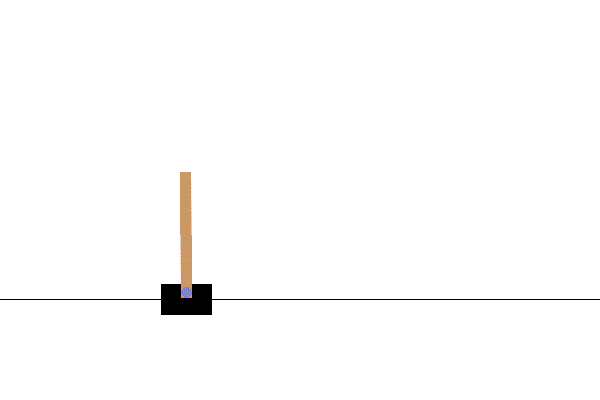

In [9]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

# Running on untrained model 

In [13]:
# Grab model 
model_untrained = ActorCritic(num_actions, num_hidden_units)

In [14]:
# Visualize 
display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]

    state = tf.constant(env.reset(), dtype=tf.float32)
    for i in range(1, max_steps + 1):
        state = tf.expand_dims(state, 0)
        action_probs, _ = model(state)
        action = np.argmax(np.squeeze(action_probs))

        state, _, done, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)

        # Render screen every 10 steps
        if i % 10 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))

        if done:
            break

    return images


# Save GIF image
images = render_episode(env, model_untrained, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/Users/alanwang/opt/anaconda3/envs/tf/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "



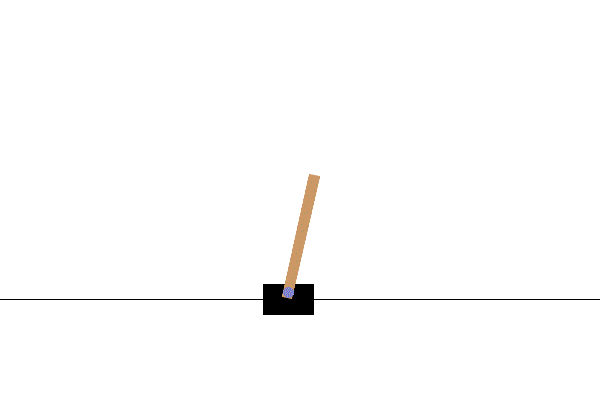

In [15]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)